In [1]:
import numpy as np
from keras import layers
from keras import optimizers
from keras.models import Model
from keras_contrib.layers import CRF
from keras_contrib import losses
from keras_contrib import metrics
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
DENSE_EMBEDDING = 300
LSTM_UNITS = 150
LSTM_DROPOUT = 0.5
DENSE_UNITS = 320
BATCH_SIZE = 100
MAX_EPOCHS = 8

In [3]:
from datasets import load_dataset
dataset = load_dataset("conll2003")
print(dataset)

d:\Program Files\Anaconda\envs\biLSTM-CRF\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset conll2003 (C:/Users/Chris/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)
100%|██████████| 3/3 [00:00<00:00, 499.92it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


In [4]:
train_set = dataset['train']
X_train = [feature['tokens'] for feature in train_set]
y_train = [feature['ner_tags'] for feature in train_set]

validation_set = dataset['validation']
X_val = [feature['tokens'] for feature in validation_set]
y_val = [feature['ner_tags'] for feature in validation_set]

test_set = dataset['test']
X_test = [feature['tokens'] for feature in test_set]
y_test = [feature['ner_tags'] for feature in test_set]

In [5]:
train_set_length = max([len(sentence) for sentence in X_train])
validation_set_length = max([len(sentence) for sentence in X_val])
test_set_length = max([len(sentence) for sentence in X_test])

MAX_SENTENCE = max(train_set_length, validation_set_length, test_set_length)

In [6]:
all_words = set()
for sentence in X_train:
    all_words = all_words.union(set(sentence))
for sentence in X_val:
    all_words = all_words.union(set(sentence))
for sentence in X_test:
    all_words = all_words.union(set(sentence))
all_words = list(all_words)

In [7]:
word2index = {word: idx for idx, word in enumerate(all_words)}
word2index["<UNK>"]=1
word2index["<PAD>"]=0
index2word = {idx: word for word, idx in word2index.items()}
WORD_COUNT = len(word2index)

tag2index = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8, 'PAD': 9}
# tag2index = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
index2tag = {idx: word for word, idx in tag2index.items()}
TAG_COUNT = len(tag2index)

In [8]:
embeddings = np.random.normal(scale=0.05, size=(WORD_COUNT, DENSE_EMBEDDING))

# Get relevant glove vectors
found = 0
print('Reading GloVe file (may take a while)')
with open('glove.840B.300d.txt', 'r') as f:
    for line_idx, line in enumerate(f):
        if line_idx % 100000 == 0:
            print('- At line {}'.format(line_idx))
        line = line.strip().split()
        if len(line) != 300 + 1:
            continue
        word = line[0]
        embedding = line[1:]
        if word in word2index:
            found += 1
            word_idx = word2index[word]
            embeddings[word_idx] = embedding
print('- done. Found {} vectors for {} words'.format(found, WORD_COUNT))

# Save np.array to file
np.savez_compressed('glove.npz', embeddings=embeddings)

Reading GloVe file (may take a while)
- At line 0
- At line 100000
- At line 200000
- At line 300000
- At line 400000
- At line 500000
- At line 600000
- At line 700000
- At line 800000
- At line 900000
- At line 1000000
- At line 1100000
- At line 1200000
- At line 1300000
- At line 1400000
- At line 1500000
- At line 1600000
- At line 1700000
- At line 1800000
- At line 1900000
- At line 2000000
- At line 2100000
- done. Found 26890 vectors for 30291 words


In [9]:
X_train = [[word2index[word] for word in sentence] for sentence in X_train]
X_train = [sentence + [word2index["<PAD>"]] * (MAX_SENTENCE - len(sentence)) for sentence in X_train]
y_train = [sentence + [tag2index["PAD"]] * (MAX_SENTENCE - len(sentence)) for sentence in y_train]
# y_train = [sentence + [tag2index["O"]] * (MAX_SENTENCE - len(sentence)) for sentence in y_train]
y_train = [np.eye(TAG_COUNT)[sentence] for sentence in y_train]

X_val = [[word2index[word] for word in sentence] for sentence in X_val]
X_val = [sentence + [word2index["<PAD>"]] * (MAX_SENTENCE - len(sentence)) for sentence in X_val]
y_val = [sentence + [tag2index["PAD"]] * (MAX_SENTENCE - len(sentence)) for sentence in y_val]
# y_val = [sentence + [tag2index["O"]] * (MAX_SENTENCE - len(sentence)) for sentence in y_val]
y_val = [np.eye(TAG_COUNT)[sentence] for sentence in y_val]

X_test = [[word2index[word] for word in sentence] for sentence in X_test]
X_test = [sentence + [word2index["<PAD>"]] * (MAX_SENTENCE - len(sentence)) for sentence in X_test]
y_test = [sentence + [tag2index["PAD"]] * (MAX_SENTENCE - len(sentence)) for sentence in y_test]
# y_test = [sentence + [tag2index["O"]] * (MAX_SENTENCE - len(sentence)) for sentence in y_test]
y_test = [np.eye(TAG_COUNT)[sentence] for sentence in y_test]

In [10]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [11]:
# biLSTM-CRF Model
input_layer = layers.Input(shape=(MAX_SENTENCE,))

# Word Embeddings matrix
embedding_matrix = np.load('glove.npz')['embeddings']
embedding_matrix[0] = 0
embedding_matrix[1] = 0

embedding_layer = layers.Embedding(
    input_dim=WORD_COUNT,
    output_dim=DENSE_EMBEDDING,
    input_length=MAX_SENTENCE,
    weights=[embedding_matrix],
    trainable=False,
)

embedded_sequences = embedding_layer(input_layer)
embedded_sequences = layers.Dropout(0.5)(embedded_sequences)

model = layers.Bidirectional(layers.LSTM(LSTM_UNITS, recurrent_dropout=LSTM_DROPOUT, return_sequences=True))(embedded_sequences)

model = layers.TimeDistributed(layers.Dense(DENSE_UNITS, activation="relu"))(model)

crf_layer = CRF(units=TAG_COUNT)
output_layer = crf_layer(model)

ner_model = Model(input_layer, output_layer)

loss = losses.crf_loss
acc_metric = metrics.crf_accuracy
opt = optimizers.Adam(lr=0.01)

ner_model.compile(optimizer=opt, loss=loss, metrics=[acc_metric])

ner_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 124)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 124, 300)          9087300   
_________________________________________________________________
dropout_1 (Dropout)          (None, 124, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 124, 300)          541200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 124, 320)          96320     
_________________________________________________________________
crf_1 (CRF)                  (None, 124, 10)           3330      
Total params: 9,728,150
Trainable params: 640,850
Non-trainable params: 9,087,300
___________________________________________

Train on 14041 samples, validate on 3250 samples
Epoch 1/8
14041/14041 [==============================] - 107s 8ms/step - loss: 0.0635 - crf_accuracy: 0.9772 - val_loss: 1.8634e-04 - val_crf_accuracy: 0.9961
Epoch 2/8
14041/14041 [==============================] - 85s 6ms/step - loss: -0.0048 - crf_accuracy: 0.9959 - val_loss: -0.0150 - val_crf_accuracy: 0.9974
Epoch 3/8
14041/14041 [==============================] - 86s 6ms/step - loss: -0.0194 - crf_accuracy: 0.9969 - val_loss: -0.0271 - val_crf_accuracy: 0.9976
Epoch 4/8
14041/14041 [==============================] - 89s 6ms/step - loss: -0.0325 - crf_accuracy: 0.9974 - val_loss: -0.0392 - val_crf_accuracy: 0.9977
Epoch 5/8
14041/14041 [==============================] - 88s 6ms/step - loss: -0.0443 - crf_accuracy: 0.9975 - val_loss: -0.0495 - val_crf_accuracy: 0.9975
Epoch 6/8
14041/14041 [==============================] - 90s 6ms/step - loss: -0.0515 - crf_accuracy: 0.9961 - val_loss: -0.0578 - val_crf_accuracy: 0.9964
Epoch 7/8
14

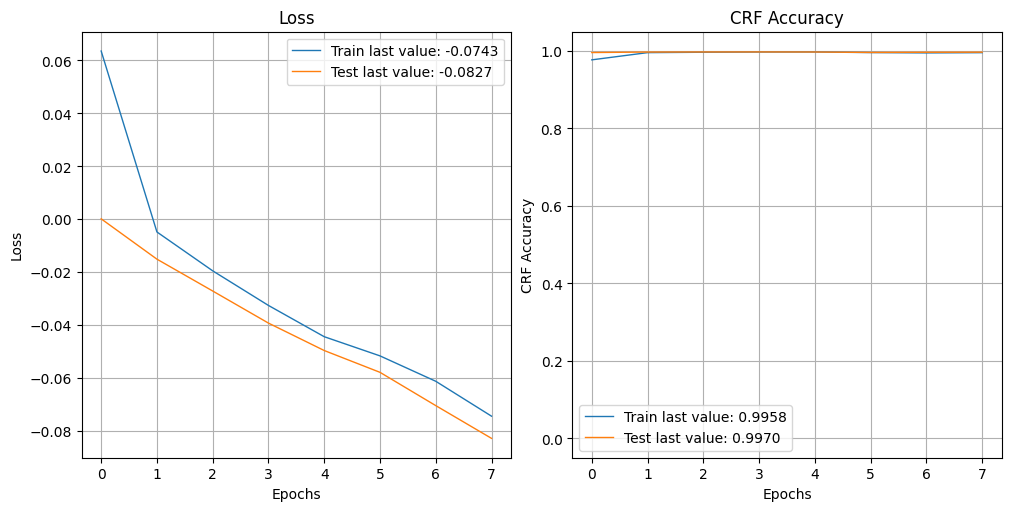



3453/3453 [==============================] - 10s 3ms/step

Test accuracy: 0.996322512626648


In [12]:
# Training Model

history = ner_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_data=(X_val, y_val), verbose=1)

plot_history(history.history)
plt.show()

print("\n")
test_loss, test_acc = ner_model.evaluate(X_test, y_test, verbose=1)
print('\nTest accuracy:', test_acc)

y_predict = ner_model.predict(X_test)
y_predict = pred = np.argmax(y_predict, axis=-1)

X_test_orig = [feature['tokens'] for feature in test_set]
X_test_len = [len(sentence) for sentence in X_test_orig]
y_pred = [[index2tag[tag_idx] for tag_idx in y_predict[i]] for i in range(y_predict.shape[0])]
y_pred = [sentence[:sentencelen] for sentence, sentencelen in zip(y_pred, X_test_len)]

y_test_orig = [feature['ner_tags'] for feature in test_set]
y_true = [[index2tag[tag_idx] for tag_idx in sentence] for sentence in y_test_orig]

In [13]:
# create a new list to hold the cleaned sequences
IOB2_pred = []
IOB2_true = []

# iterate through each sequence in A and remove the corresponding elements in B
for seq_pred, seq_true in zip(y_pred, y_true):
    # create a new list to hold the cleaned sequence
    IOB2_seq_pred = []
    IOB2_seq_true = []

    # iterate through each label in the sequence
    for label_pred, label_true in zip(seq_pred, seq_true):
        # if the label is not "PAD", append it to the cleaned sequence
        if label_pred != "PAD":
            IOB2_seq_pred.append(label_pred)
            IOB2_seq_true.append(label_true)

    # append the cleaned sequence to the new list
    IOB2_pred.append(IOB2_seq_pred)
    IOB2_true.append(IOB2_seq_true)


In [14]:
from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
from seqeval.scheme import IOB2

print(accuracy_score(y_true, y_pred))
print(accuracy_score(IOB2_true, IOB2_pred))
print("\n")
print("F1-score:", f1_score(IOB2_true, IOB2_pred,  mode='strict', scheme=IOB2))
print(classification_report(IOB2_true, IOB2_pred, mode='strict', scheme=IOB2))
print("\n")
print("F1-score:", f1_score(IOB2_true, IOB2_pred))
print(classification_report(IOB2_true, IOB2_pred))

0.9664261871433186
0.9703128716296568


F1-score: 0.860211236353954
              precision    recall  f1-score   support

         LOC       0.87      0.91      0.89      1668
        MISC       0.77      0.73      0.75       699
         ORG       0.85      0.79      0.82      1661
         PER       0.90      0.93      0.92      1608

   micro avg       0.86      0.86      0.86      5636
   macro avg       0.85      0.84      0.84      5636
weighted avg       0.86      0.86      0.86      5636



F1-score: 0.8583797155225726
              precision    recall  f1-score   support

         LOC       0.86      0.91      0.89      1668
        MISC       0.77      0.74      0.75       702
         ORG       0.84      0.79      0.81      1661
         PER       0.90      0.94      0.92      1613

   micro avg       0.86      0.86      0.86      5644
   macro avg       0.84      0.84      0.84      5644
weighted avg       0.85      0.86      0.86      5644



In [15]:
# # Predicting
# import re
# import string

# # sentence = "President Obama became the first sitting American president to visit Hiroshima"
# sentence = "Chinese President Xi Jinping walks into the St. George's Hall at the Kremlin in Moscow, Russia, March 21, 2023. Xi on Tuesday held talks with Putin in Moscow. Putin held a solemn welcome ceremony for Xi Jinping at the St. George's Hall."

# re_tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")
# sentence = re_tok.sub(r"  ", sentence).split()

# padded_sentence = sentence + ["<PAD>"] * (MAX_SENTENCE - len(sentence))
# padded_sentence = [word2index.get(w, 0) for w in padded_sentence]

# pred = ner_model.predict(np.array([padded_sentence]))
# pred = np.argmax(pred, axis=-1)

# retval = ""
# for w, p in zip(sentence, pred[0]):
#     retval = retval + "{:15}: {:5}".format(w, index2tag[p]) + "\n"
# print(retval)